# Intro Task, Object Localization 

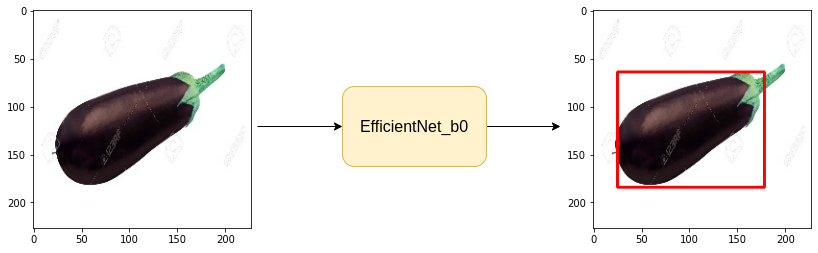

In [ ]:
# # install libraries/packages/modules 

# %pip install -U git+https://github.com/albumentations-team/albumentations
# %pip install timm
# %pip install --upgrade opencv-contrib-python

In [1]:
# # Download Dataset

# !git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 1.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('object-localization-dataset')

# Configurations

In [53]:
CSV_FILE = '/home/btech/nityanand.mathur/object-localization-dataset/train.csv'
DATA_DIR = '/home/btech/nityanand.mathur/object-localization-dataset/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 40
LR = 0.001
BATCH_SIZE = 16
IMG_SIZE = 140

MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

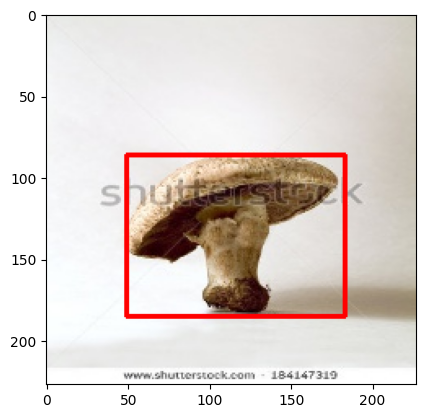

In [23]:
def disp(i):
    row = df.iloc[i]
    img = cv2.imread(DATA_DIR + row.img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pt1 = (row.xmin, row.ymin)
    pt2 = (row.xmax, row.ymax)
    bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2) #(255,0,0) -> (R,G,B)
    return bnd_box_img

plt.imshow(disp(2))

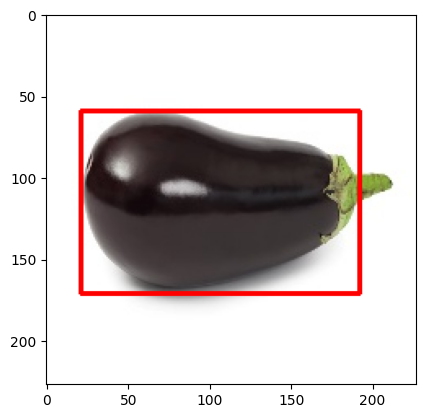

In [24]:
plt.imshow(disp(184))

In [25]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [26]:
import albumentations as A

In [30]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

val_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [31]:
from torch.utils.data import Dataset

In [32]:
class ObjLocDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        xmax = row.xmax
        ymin = row.ymin
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)
        
        return img, bbox

In [33]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, val_augs)

In [34]:
print(f'total examples in trainset: {len(trainset)}')
print(f'total examples in validset: {len(validset)}')

total examples in trainset: 148
total examples in validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


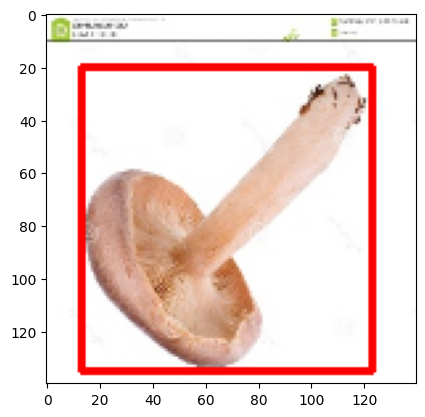

In [39]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [40]:
from torch.utils.data import DataLoader

In [41]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle=False)

In [42]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [43]:
for images, bboxes in trainloader:
    break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [44]:
from torch import nn 
import timm

In [55]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)

    def forward(self, images, gt_bboxes=None):

        bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [56]:
model = ObjLocModel()
model.to(DEVICE);

In [57]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [58]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0
    model.train()

    for data in tqdm(dataloader):

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(dataloader)

In [62]:
def valid_fn(model, dataloader):
    total_loss = 0
    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss/len(dataloader)

# Training Loop

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [64]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = valid_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'ObjLOC.pt')
        print('Weights Saved')
        best_valid_loss = valid_loss
    
    print(f"Epoch: {i+1} | Train Loss: {train_loss} | Val Loss: {valid_loss}")
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 1 | Train Loss: 1140.6040771484375 | Val Loss: 574.5734659830729


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 2 | Train Loss: 729.7578186035156 | Val Loss: 233.28372192382812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 3 | Train Loss: 526.9785949707032 | Val Loss: 183.3726806640625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 4 | Train Loss: 362.55372314453126 | Val Loss: 129.91956329345703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 263.733625793457 | Val Loss: 149.35125732421875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 6 | Train Loss: 210.65380401611327 | Val Loss: 111.06484731038411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 7 | Train Loss: 162.55936737060546 | Val Loss: 103.79765955607097


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 148.88255767822267 | Val Loss: 154.87046813964844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 110.35954437255859 | Val Loss: 108.71824137369792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 10 | Train Loss: 101.79802932739258 | Val Loss: 99.3747329711914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 11 | Train Loss: 116.39019355773925 | Val Loss: 79.96693929036458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 92.42053527832032 | Val Loss: 100.21621958414714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 76.72036781311036 | Val Loss: 98.7770487467448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 100.76883087158203 | Val Loss: 150.10212198893228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 91.45562591552735 | Val Loss: 114.72633870442708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 73.5922399520874 | Val Loss: 90.58209737141927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 17 | Train Loss: 57.7039493560791 | Val Loss: 74.67281595865886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 18 | Train Loss: 50.45947914123535 | Val Loss: 53.60510126749674


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 57.16160163879395 | Val Loss: 93.15763092041016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 20 | Train Loss: 55.234099578857425 | Val Loss: 51.945971171061196


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 68.81951141357422 | Val Loss: 60.8794059753418


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 62.62029876708984 | Val Loss: 66.42444101969402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 50.43123798370361 | Val Loss: 65.82067998250325


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Train Loss: 44.18836078643799 | Val Loss: 69.1659558614095


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 44.7757791519165 | Val Loss: 62.95794423421224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights Saved
Epoch: 26 | Train Loss: 40.070301628112794 | Val Loss: 48.945603688557945


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Train Loss: 45.43737239837647 | Val Loss: 56.28494008382162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | Train Loss: 40.72446899414062 | Val Loss: 70.61678314208984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | Train Loss: 40.20736560821533 | Val Loss: 56.155687967936196


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Train Loss: 41.08736724853516 | Val Loss: 84.89966583251953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Train Loss: 48.22619075775147 | Val Loss: 61.063226064046226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Train Loss: 56.045311737060544 | Val Loss: 105.7700589497884


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Train Loss: 45.210825729370114 | Val Loss: 50.20215098063151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | Train Loss: 37.376250648498534 | Val Loss: 75.16394933064778


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Train Loss: 47.06744327545166 | Val Loss: 70.02651468912761


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Train Loss: 49.00901985168457 | Val Loss: 84.49778493245442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Train Loss: 38.86332340240479 | Val Loss: 66.3694076538086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Train Loss: 34.881966018676756 | Val Loss: 94.11688486735027


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | Train Loss: 39.33258953094482 | Val Loss: 71.6628532409668


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 | Train Loss: 30.065166091918947 | Val Loss: 64.15765380859375


# Inference

In [65]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


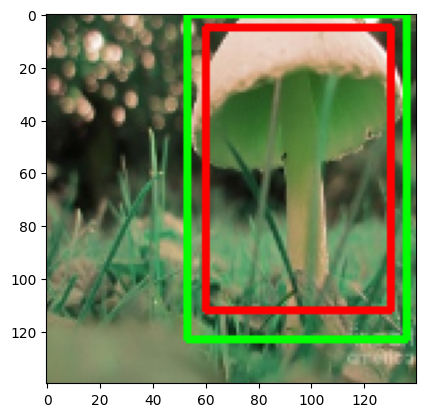

In [68]:
model.load_state_dict(torch.load('ObjLOC.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[31]
    image = image.unsqueeze(0).to(DEVICE)

    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)